In [196]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as plt
from pathlib import Path 
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split

In [197]:
# Load employee_info source table
data1 = pd.read_csv("/Users/leanhe/Desktop/Github/EmployeeChurnAnalyticslocal/Employee_info.csv")

In [198]:
# Explore table information: data size, columns, data quality, data type
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1478 non-null   float64
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1479 non-null   object 
 14  HourlyRa

### Drop Columns with No Variance

In [199]:
no_variance_cols = [col for col in data1.columns if data1[col].nunique() == 1]
no_variance_cols

['EmployeeCount', 'Over18', 'StandardHours']

In [200]:
data1 = data1.drop(columns=no_variance_cols)

### Remove Redundant Features with Overlapping Information
Some columns convey the same information at different levels of granularity—for example, both “Age” and “AgeGroup” reflect age-related data. In such cases, I retain the grouped or more general column and remove the one with overly detailed values to reduce redundancy and simplify the analysis.  
- Age/AgeGroup: Keep AgeGroup
- DailyRate/HourlyRate/MonthlyRate/MonthlyIncome/SalarySlab: Keep SalarySlab
- EnvironmentSatisfaction/RelationshipSatisfaction/JobSatisfaction: Keep JobSatisfaction

In [201]:
data1.drop(columns=[
        'Age', 
        'DailyRate', 
        'HourlyRate',
        'MonthlyRate', 
        'MonthlyIncome',
        'EnvironmentSatisfaction',
        'RelationshipSatisfaction'
], inplace=True)

In [202]:
data1.drop(columns='EmpID', inplace=True) #Employee ID is not a feature so dropping it.

### Removing Duplications

In [203]:
print(data1.duplicated().any())
print(data1.duplicated().sum())

True
7


In [204]:
# Drop duplications
data1 = data1.drop_duplicates()
print(data1.duplicated().any())
print(data1.duplicated().sum())

False
0


### Checking Inconsistent Formatting

In [205]:
categorical_cols = data1.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data1[col].unique())


Column: AgeGroup
['18-25' '26-35' '36-45' '46-55' '55']

Column: Attrition
['Yes' 'No']

Column: BusinessTravel
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel' 'TravelRarely']

Column: Department
['Research & Development' 'Sales' 'Human Resources']

Column: EducationField
['Life Sciences' 'Medical' 'Marketing' 'Technical Degree' 'Other'
 'Human Resources']

Column: Gender
['Male' 'Female' nan]

Column: JobRole
['Laboratory Technician' 'Sales Representative' 'Research Scientist'
 'Human Resources' 'Manufacturing Director' 'Sales Executive'
 'Healthcare Representative' 'Research Director' 'Manager']

Column: MaritalStatus
['Single' 'Divorced' 'Married']

Column: SalarySlab
['Upto 5k' '5k-10k' '10k-15k' '15k+']

Column: OverTime
['No' 'Yes']


All values are standardized and consistently formatted.

### Split Data into Training Set and Test Set, Attributes and Label

In [284]:
# Random sampling, split into train and test sets 
data1_attributes = data1.drop("Attrition", axis = 1)
data1_label = data1["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(
    data1_attributes, data1_label, test_size=0.3, random_state=123
)

## Data Preparation (Data Exploration for Pipeline Development)

### Step 1: Filling Null values

In [261]:
# rows that contain at least one NA
null_rows = X_train[X_train.isna().any(axis=1)].copy()

null_rows['null_count'] = null_rows.isna().sum(axis=1)
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 338 to 1205
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AgeGroup                 35 non-null     object 
 1   BusinessTravel           35 non-null     object 
 2   Department               35 non-null     object 
 3   DistanceFromHome         34 non-null     float64
 4   Education                35 non-null     int64  
 5   EducationField           35 non-null     object 
 6   EmployeeNumber           35 non-null     int64  
 7   Gender                   34 non-null     object 
 8   JobInvolvement           35 non-null     int64  
 9   JobLevel                 35 non-null     int64  
 10  JobRole                  35 non-null     object 
 11  JobSatisfaction          34 non-null     float64
 12  MaritalStatus            35 non-null     object 
 13  SalarySlab               35 non-null     object 
 14  NumCompaniesWorked       35 n

Out of 1,480 * 0.7 = 1036 rows, 35 contain null values, with most having only a single missing entry.  
Since fewer than 5% of rows contain missing values, dropping them would typically be acceptable. However, assuming stakeholders prefer to retain all data, I’ve opted to impute the missing values based on informed judgment.

In [262]:
null_rows.isna().sum()

AgeGroup                    0
BusinessTravel              0
Department                  0
DistanceFromHome            1
Education                   0
EducationField              0
EmployeeNumber              0
Gender                      1
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             1
MaritalStatus               0
SalarySlab                  0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager       33
null_count                  0
dtype: int64

Columns with missing value:
DistanceFromHome(float64), Gender(object), HourlyRate(float64), JobSatisfaction(float64), YearswithCurrManager(float64).  

#### Numerical columns
I assessed skewness to choose if I fill the missing value with mean, median, or mode.

<Axes: >

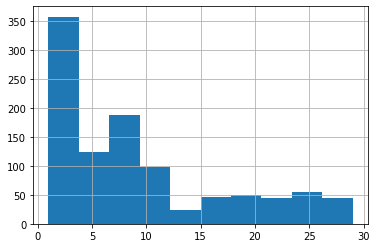

In [263]:
X_train['DistanceFromHome'].hist() # right-skewed

<Axes: >

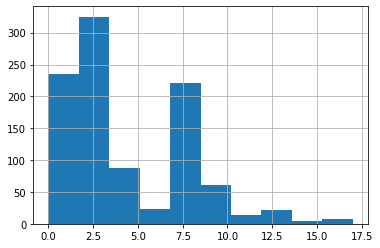

In [264]:
X_train['YearsWithCurrManager'].hist() #right-skewed

I'm going to fill with median for column 'DistanceFromHome' and 'YearsWithCurrManager' since they are right-skewed. 

#### Categorical Attributes
I'm going to fill with mode for categorical variables.

#### Fill the Missing Values

In [267]:
from sklearn.impute import SimpleImputer

imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

# find numeric and categorical attributes
X_train_num = X_train.select_dtypes(include=[np.number])
X_train_cat = X_train.select_dtypes(include=["object", "category"])

#Apply
imputer_num.fit(X_train_num)
imputer_cat.fit(X_train_cat)

X_num = imputer_num.transform(X_train_num)
X_cat = imputer_cat.transform(X_train_cat)

print(X_num.shape[0])
print(X_cat.shape[0])

1031
1031


In [268]:
# Check if all missing values are filled

X_num_df = pd.DataFrame(X_num, columns=data1_a_num.columns, index=data1_a_num.index)
X_cat_df = pd.DataFrame(X_cat, columns=data1_a_cat.columns, index=data1_a_cat.index)
X_train_tr = pd.concat([X_num_df, X_cat_df], axis=1)
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 838 to 1396
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DistanceFromHome         1031 non-null   float64
 1   Education                1031 non-null   float64
 2   EmployeeNumber           1031 non-null   float64
 3   JobInvolvement           1031 non-null   float64
 4   JobLevel                 1031 non-null   float64
 5   JobSatisfaction          1031 non-null   float64
 6   NumCompaniesWorked       1031 non-null   float64
 7   PercentSalaryHike        1031 non-null   float64
 8   PerformanceRating        1031 non-null   float64
 9   StockOptionLevel         1031 non-null   float64
 10  TotalWorkingYears        1031 non-null   float64
 11  TrainingTimesLastYear    1031 non-null   float64
 12  WorkLifeBalance          1031 non-null   float64
 13  YearsAtCompany           1031 non-null   float64
 14  YearsInCurrentRole       10

### Step 2: Convert Categorical Attributes

In [269]:
X_train_cat.columns

Index(['AgeGroup', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'SalarySlab', 'OverTime'],
      dtype='object')

1. Ordinal Attributes

In [270]:
X_train_ord = X_train[["AgeGroup", "SalarySlab"]]

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
data1_a_ord_encoded = ordinal_encoder.fit_transform(X_train_ord)
ordinal_encoder.categories_

[array(['18-25', '26-35', '36-45', '46-55', '55'], dtype=object),
 array(['10k-15k', '15k+', '5k-10k', 'Upto 5k'], dtype=object)]

The order for SalarySlab is not right - 'Upto 5k' should be the lowest level. 

In [271]:
ordinals = [
    sorted(X_train["AgeGroup"].unique().tolist()),  # auto sort age group
    ['Upto 5k', '5k-10k', '10k-15k', '15k+']        # custom salary order
]

ordinal_encoder = OrdinalEncoder(categories=ordinals)
data1_a_ord_encoded = ordinal_encoder.fit_transform(X_train_ord)

# view the category order for confirmation
ordinal_encoder.categories_

[array(['18-25', '26-35', '36-45', '46-55', '55'], dtype=object),
 array(['Upto 5k', '5k-10k', '10k-15k', '15k+'], dtype=object)]

2. Nominal Attributes

In [272]:
X_train_nom = X_train[['BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime']]

from sklearn.preprocessing import OneHotEncoder 
nom_encoder = OneHotEncoder()
X_train_nom_1hot = nom_encoder.fit_transform(X_train_nom)
X_train_nom_1hot = X_train_nom_1hot.toarray()
X_train_nom_1hot

array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.]])

## 2. Data Processing

### Feature Scaling and Transformation

In [273]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler

# Numeric and Categorical Attributes Lists
num_attribs = X_train.select_dtypes(include=[np.number]).columns.tolist()
ord_attribs = ['AgeGroup', 'SalarySlab']
nom_attribs = [
    col for col in X_train.select_dtypes(include=["object"]).columns
    if col not in ["AgeGroup", "SalarySlab"]
]

# Order for Ordinal Attributes
ordinals = [
    sorted(X_train["AgeGroup"].unique().tolist()),  # auto sort age groups
    ['Upto 5k', '5k-10k', '10k-15k', '15k+']         # custom salary order
]

# Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=ordinals))
])

nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('1hot_encoder', OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_attribs),
        ("ord", ordinal_pipeline, ord_attribs),
        ("nom", nominal_pipeline, nom_attribs)
    ],
    remainder="passthrough"
)


## Select and Train a Model

In [274]:
# Try Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_reg = Pipeline([
    ('preprocessing', preprocessing),
    ('log_reg', LogisticRegression())
])
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DistanceFromHome',
                                                   'Education',
                                                   'EmployeeNumber',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'StockO...
                                                                                               '46-55',
                                                                                               '55'],
                                                                                              ['Upto '
                                                                                               '5k',
                                                                                               '5k-10k',
                                                                                               '10k-15k',
                                                                                               '15k+']]))]),
                                                  ['AgeGroup', 'SalarySlab']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime'])])),
                ('log_reg', LogisticRegression())])

In [275]:
y_pred = log_reg.predict(X_test)
y_pred[:5]

array(['No', 'Yes', 'No', 'No', 'No'], dtype=object)

              precision    recall  f1-score   support

         Yes       0.87      0.97      0.91       365
          No       0.65      0.29      0.40        77

    accuracy                           0.85       442
   macro avg       0.76      0.63      0.65       442
weighted avg       0.83      0.85      0.82       442



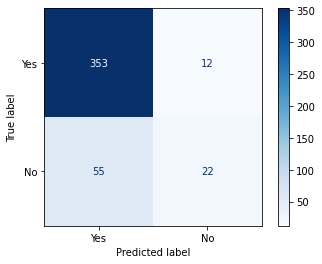

In [276]:
#Evaluate

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print(classification_report(y_test, y_pred, target_names=["Yes", "No"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")

So far, Logistic Regression Model is doing well at recalling and predicting leavers. Let's see if we can only focus on the most important coefficients to simplify the model.

In [277]:
# 1. Get feature names after preprocessing
feature_names = log_reg.named_steps['preprocessing'].get_feature_names_out()

# 2. Get logistic regression coefficients
coefficients = log_reg.named_steps['log_reg'].coef_[0]  # Assuming binary classification

# 3. Combine and sort
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

# 4. Group nominal features together
top_features = coef_df.copy()
top_features["BaseFeature"] = top_features["Feature"].str.extract(r'nom__([A-Za-z]+)_')[0] \
                                          .fillna(top_features["Feature"].str.extract(r'num__([A-Za-z]+)')[0])
grouped_features = top_features.groupby("BaseFeature")["Coefficient"].apply(lambda x: sum(abs(x)))
grouped_features = grouped_features.sort_values(ascending=False).reset_index()

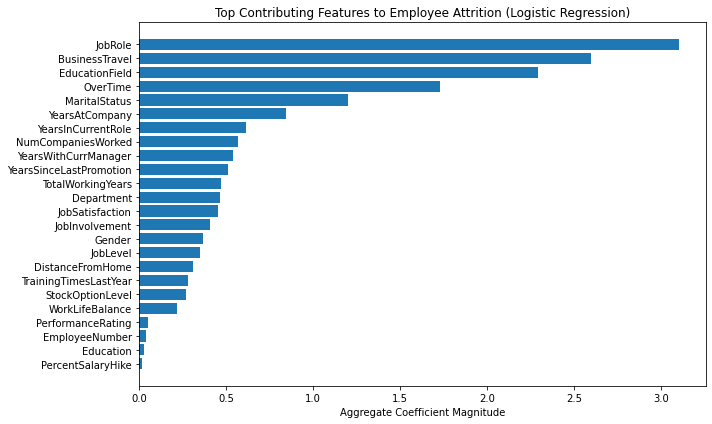

In [278]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(grouped_features["BaseFeature"], grouped_features["Coefficient"])
plt.xlabel("Aggregate Coefficient Magnitude")
plt.title("Top Contributing Features to Employee Attrition (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Check Whether Combining Similar Attributes Will Simplify Model
I noticed that some attributes are similar. For example, 'YearsAtCompany' and 'YearsInCurrentRole' share similar information, especially for this company where internal transfer opportunity is not available. Therefore, combining similar features will simplify the model and reduce redundancy.  
- If the correlation is > 0.8, then that's a strong sign that they overlap.

In [279]:
# Explore Correlation

data1_a[["YearsWithCurrManager", "YearsAtCompany","YearsSinceLastPromotion", "YearsInCurrentRole"]].corr()

,YearsWithCurrManager,YearsAtCompany,YearsSinceLastPromotion,YearsInCurrentRole
YearsWithCurrManager,1.000000,0.771112,0.520688,0.701084
YearsAtCompany,0.771112,1.000000,0.599951,0.763781
YearsSinceLastPromotion,0.520688,0.599951,1.000000,0.546311
YearsInCurrentRole,0.701084,0.763781,0.546311,1.000000


The attributes don't have a correlation > 0.8. Therefore, I'll leave it as it is.

### Build Logistic Regression Model Based on Most Important Features

In [285]:
# new Attribute X
top_10_features = grouped_features["BaseFeature"].head(10).tolist()
X_top10 = data1[top_10_features]

#new Label Y
y_label_top10 = data1["Attrition"]

# Split into new Train and Test sets for just top_10_features
X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(
    X_top10, y_label_top10, test_size=0.3, random_state=123
)

# New Attribute List by Type
top10_num = [col for col in top_10_features if col in num_attribs]
top10_ord = [col for col in top_10_features if col in ord_attribs]
top10_nom = [col for col in top_10_features if col in nom_attribs]

# Use the Same Pipeline "num", "ordinal", "nominal"

# Build a new preprocessing for just top_10_features
preprocessing_top10 = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, top10_num),
        ("ord", ordinal_pipeline, top10_ord),
        ("nom", nominal_pipeline, top10_nom)
    ],
    remainder="passthrough"
)

log_reg_top10 = Pipeline([
    ('preprocessing', preprocessing_top10),
    ('log_reg', LogisticRegression())
])

log_reg_top10.fit(X_train_top10, y_train_top10)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'NumCompaniesWorked',
                                                   'YearsWithCurrManager',
                                                   'YearsSinceLastPromotion']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(stra...
                                                                   OrdinalEncoder(categories=[['18-25',
                                                                                               '26-35',
                                                                                               '36-45',
                                                                                               '46-55',
                                                                                               '55'],
                                                                                              ['Upto '
                                                                                               '5k',
                                                                                               '5k-10k',
                                                                                               '10k-15k',
                                                                                               '15k+']]))]),
                                                  []),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JobRole', 'BusinessTravel',
                                                   'EducationField', 'OverTime',
                                                   'MaritalStatus'])])),
                ('log_reg', LogisticRegression())])

In [286]:
y_pred_top10 = log_reg_top10.predict(X_test_top10)
y_pred_top10[:5]

array(['No', 'Yes', 'No', 'No', 'No'], dtype=object)

              precision    recall  f1-score   support

         Yes       0.85      0.96      0.90       365
          No       0.50      0.17      0.25        77

    accuracy                           0.83       442
   macro avg       0.67      0.57      0.58       442
weighted avg       0.79      0.83      0.79       442



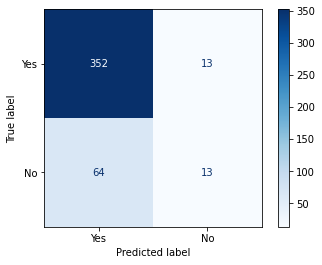

In [287]:
#Evaluate

# Classification report
print(classification_report(y_test_top10, y_pred_top10, target_names=["Yes", "No"]))

# Confusion matrix
cm = confusion_matrix(y_test_top10, y_pred_top10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")

The performance just dropped a little to none. Therefore, the simplified model is also performing well at recalling and predicting leavers. 

### Random Forest Classifier

In [288]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=123))
])

forest_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DistanceFromHome',
                                                   'Education',
                                                   'EmployeeNumber',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'StockO...
                                                                                               '5k-10k',
                                                                                               '10k-15k',
                                                                                               '15k+']]))]),
                                                  ['AgeGroup', 'SalarySlab']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime'])])),
                ('random_forest', RandomForestClassifier(random_state=123))])

In [290]:
y_pred_rf = forest_clf.predict(X_test)
y_pred_rf[:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

              precision    recall  f1-score   support

         Yes       0.85      0.99      0.91       365
          No       0.80      0.16      0.26        77

    accuracy                           0.85       442
   macro avg       0.82      0.57      0.59       442
weighted avg       0.84      0.85      0.80       442



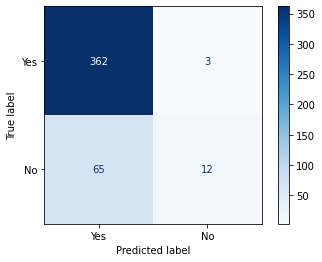

In [291]:
#Evaluate

# Classification report
print(classification_report(y_test, y_pred_rf, target_names=["Yes", "No"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")

Random Forest is performing very well, 0.99 score. This is too well- the model might be overfitting. I'm creating a validation dataset to evaluate.

### XGBoost

In [299]:
from xgboost import XGBClassifier

# Concert label to binary
y_train_binary = y_train.map({'No': 0, 'Yes': 1})
y_test_binary = y_test.map({'No': 0, 'Yes': 1})

# Build model
xgb = Pipeline([
    ("preprocessing", preprocessing),
    ("xgboost", XGBClassifier(random_state=123))
])

xgb.fit(X_train, y_train_binary)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DistanceFromHome',
                                                   'Education',
                                                   'EmployeeNumber',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'StockO...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [300]:
y_pred_xgb = xgb.predict(X_test)

              precision    recall  f1-score   support

         Yes       0.87      0.98      0.92       365
          No       0.73      0.31      0.44        77

    accuracy                           0.86       442
   macro avg       0.80      0.64      0.68       442
weighted avg       0.85      0.86      0.84       442



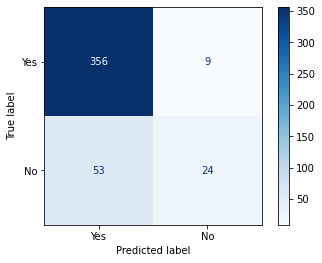

In [301]:
#Evaluate

# Classification report
print(classification_report(y_test_binary, y_pred_xgb, target_names=["Yes", "No"]))

# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")

XGB Model has a high recall for both "Yes" and "No". In other words, XGB Model handles class imbalance better, and have lower false alarms while maintaining a high performance identifing leavers.

### GradientBoosting Classifier

In [302]:
from sklearn.ensemble import GradientBoostingClassifier

gradient = Pipeline([
    ("preprocessing", preprocessing),
    ("gradientboost", GradientBoostingClassifier(random_state=123))
])

gradient.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DistanceFromHome',
                                                   'Education',
                                                   'EmployeeNumber',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'StockO...
                                                                                               '5k-10k',
                                                                                               '10k-15k',
                                                                                               '15k+']]))]),
                                                  ['AgeGroup', 'SalarySlab']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('1hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime'])])),
                ('gradientboost',
                 GradientBoostingClassifier(random_state=123))])

In [303]:
y_pred_gradient = gradient.predict(X_test)

              precision    recall  f1-score   support

         Yes       0.87      0.98      0.92       365
          No       0.75      0.31      0.44        77

    accuracy                           0.86       442
   macro avg       0.81      0.64      0.68       442
weighted avg       0.85      0.86      0.84       442



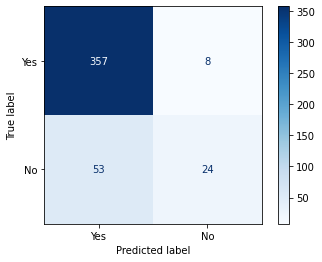

In [304]:
#Evaluate

# Classification report
print(classification_report(y_test, y_pred_gradient, target_names=["Yes", "No"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gradient)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")

GradientBoosting Classifier performance as good as XGBoosting.